## Detalle sobre este notebook (fv_CRISIS_2008):
* **OBJETIVO:** Analizar algunos aspectos **con variables bien pobladas** vinculadas a eventos reconocidos
* PERÍODO todos los de Chile (14 al 21)
* EVENTO: Crisis global generada por la cída del mercado inmobiliario en USA

#### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from networkx.algorithms import community
import community as community_louvain


#### Cargar df_5_extended

In [2]:
df_5_extended = pd.read_excel('df_5_extended.xlsx')
df_5_extended.head()

countryname  ventana_5    per101   per102    per103    per104    per105  \
0     Albania         16  1.770988  0.00000  0.031388  3.046506  0.015910   
1     Albania         17  2.392570  0.00000  0.000000  2.757403  0.026619   
2   Argentina         14  0.000000  0.00000  4.619213  0.448618  0.828036   
3   Argentina         16  0.127092  0.01007  0.362805  0.703417  0.050417   
4   Argentina         17  0.000000  0.00000  0.022605  0.113333  0.135937   

     per106    per107    per108  ...   per6013  per6014  per6061  per6071  \
0  0.032313  3.406129  1.114989  ...  2.021481      0.0      0.0      0.0   
1  0.023948  3.523162  1.452779  ...  0.989546      0.0      0.0      0.0   
2  0.338070  2.955090  0.000000  ...  0.000000      0.0      0.0      0.0   
3  0.860368  2.739447  1.966051  ...  0.000000      0.0      0.0      0.0   
4  0.233844  2.621821  1.451604  ...  0.000000      0.0      0.0      0.0   

   per6072  per6081   per7051   per7052  per7061  per7062  
0      0.0      0.0  0.637892  0.363756      0.0      0.0  
1      0.0      0.0  0.897238  0.508457      0.0      0.0  
2      0.0      0.0  0.000000  0.000000      0.0      0.0  
3      0.0      0.0  0.000000  0.000000      0.0      0.0  
4      0.0      0.0  0.000000  0.000000      0.0      0.0  

[5 rows x 112 columns]

In [3]:
df_5_extended.shape

(1386, 112)

In [4]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()


Dominio      Nombre_Dominio Variable_per  \
0  Domain_1  External Relations       per101   
1  Domain_1  External Relations       per102   
2  Domain_1  External Relations       per103   
3  Domain_1  External Relations       per104   
4  Domain_1  External Relations       per105   

                           Detalle_Dominio  
0  Foreign Special Relationships: Positive  
1  Foreign Special Relationships: Negative  
2                         Anti-Imperialism  
3                       Military: Positive  
4                       Military: Negative

In [5]:
all_per_variables = [col for col in df_5_extended.columns if col.startswith('per')]
all_per_variables

['per101',
 'per102',
 'per103',
 'per104',
 'per105',
 'per106',
 'per107',
 'per108',
 'per109',
 'per110',
 'per201',
 'per202',
 'per203',
 'per204',
 'per301',
 'per302',
 'per303',
 'per304',
 'per305',
 'per401',
 'per402',
 'per403',
 'per404',
 'per405',
 'per406',
 'per407',
 'per408',
 'per409',
 'per410',
 'per411',
 'per412',
 'per413',
 'per414',
 'per415',
 'per416',
 'per501',
 'per502',
 'per503',
 'per504',
 'per505',
 'per506',
 'per507',
 'per601',
 'per602',
 'per603',
 'per604',
 'per605',
 'per606',
 'per607',
 'per608',
 'per701',
 'per702',
 'per703',
 'per704',
 'per705',
 'per706',
 'per1011',
 'per1012',
 'per1013',
 'per1014',
 'per1015',
 'per1016',
 'per1021',
 'per1022',
 'per1023',
 'per1024',
 'per1025',
 'per1026',
 'per1031',
 'per1032',
 'per1033',
 'per2021',
 'per2022',
 'per2023',
 'per2031',
 'per2032',
 'per2033',
 'per2041',
 'per3011',
 'per3051',
 'per3052',
 'per3053',
 'per3054',
 'per3055',
 'per4011',
 'per4012',
 'per4013',
 'per4014',


In [7]:
len(all_per_variables)

110

### MATRIZ DE ASPECTOS

In [18]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['CRISIS_FINANCIERA_2008', 'INMIGRANTES'],
    'var_1': ['per401', 'per101'],
    'var_2': ['per403', 'per201'],
    'var_3': ['per503', None],  # None indica que no hay una tercera variable para el aspecto
    'var_4': ['per504', None]  
}

df_aspectos = pd.DataFrame(data_aspectos)

# Mostrar el DataFrame 'df_aspectos' para verificar su contenido
display(df_aspectos)

aspecto   var_1   var_2   var_3   var_4
0  CRISIS_FINANCIERA_2008  per401  per403  per503  per504
1             INMIGRANTES  per101  per201    None    None

#### Años en cada período

In [19]:
# cargar períodos
df_ventana_5 = pd.read_excel('data/Ventana_5.xlsx')
df_ventana_5

agno  ventana
0    1920        1
1    1921        1
2    1922        1
3    1923        1
4    1924        1
..    ...      ...
99   2019       20
100  2020       21
101  2021       21
102  2022       21
103  2023       21

[104 rows x 2 columns]

#### Calculamos la similaridad tanto con correlación como con distancia euclideana

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from collections import defaultdict
import itertools


In [21]:
def calcular_similitudes_todos_paises(df, df_aspectos, tipo_similitud, periodo):
    """Calcula la similaridad entre todos los países para un aspecto específico y un período usando Pearson o Euclidean."""
    similarity_results = defaultdict(list)

    # Filtrar el dataframe para el período específico
    df = df[df['ventana_5'] == periodo]
    
    for _, row_aspecto in df_aspectos.iterrows():
        aspecto = row_aspecto['aspecto']
        variables = row_aspecto[['var_1', 'var_2', 'var_3', 'var_4']].dropna().tolist()

        # Filtrar datos de todos los países con las columnas relevantes
        columnas_relevantes = ['countryname', 'ventana_5'] + variables
        df_filtered = df[columnas_relevantes].copy()

        # Calcular similitudes entre todos los pares de países
        for (idx1, row1), (idx2, row2) in itertools.combinations(df_filtered.iterrows(), 2):
            country_period_1 = f"{row1['countryname']}_{row1['ventana_5']}"
            country_data_1 = row1[variables].astype(float)

            country_period_2 = f"{row2['countryname']}_{row2['ventana_5']}"
            country_data_2 = row2[variables].astype(float)

            # Asignar similaridad de cero si uno de los países tiene todos los valores en cero
            if country_data_1.sum() == 0 or country_data_2.sum() == 0:
                similarity = 0  
            else:
                if tipo_similitud == 'pearson':
                    # Calcular la correlación de Pearson
                    corr = country_data_1.corr(country_data_2, method='pearson')
                    # print(f"Pearson/ {aspecto} / {country_period_1} / {country_period_2} / {corr}")
                    similarity = 0 if pd.isna(corr) else abs(corr)
                elif tipo_similitud == 'euclidean':
                    dist = euclidean(country_data_1, country_data_2)
                    similarity = 1 / (1 + dist) if not np.isnan(dist) else 0

            similarity_results[(aspecto, country_period_1, country_period_2)].append(similarity)

    # Convertir a DataFrame
    final_results = {
        key: np.mean(values) for key, values in similarity_results.items()
    }

    df_similarities = pd.DataFrame(
        list(final_results.items()), 
        columns=['Aspecto_Country_Period1_Period2', 'Similarity']
    )
    df_similarities[['Aspecto', 'Country_Period_1', 'Country_Period_2']] = pd.DataFrame(
        df_similarities['Aspecto_Country_Period1_Period2'].tolist(), index=df_similarities.index
    )
    df_similarities.drop('Aspecto_Country_Period1_Period2', axis=1, inplace=True)

    # Eliminar duplicados
    df_similarities = df_similarities.groupby(['Country_Period_1', 'Country_Period_2'], as_index=False).agg({'Similarity': 'mean'})
    
    return df_similarities


#### Generamos las Redes, Comunidades y Métricas de Centralidad

In [22]:
def generar_red_y_calcular_metricas(df_similarity, aspecto, tipo_similitud, porcentaje, periodo):
    """
    Genera una red de similaridad, calcula las métricas de centralidad, 
    y analiza las comunidades detectadas para un aspecto específico.
    """
    resumen = {'Aspecto': aspecto, 'Criterio': tipo_similitud}
    
    # Obtener los años "Desde" y "Hasta" para el período dado
    desde_hasta_df = df_ventana_5[df_ventana_5['ventana'] == periodo]
    desde = desde_hasta_df['agno'].min()
    hasta = desde_hasta_df['agno'].max()
    
    # Filtrar los x% enlaces con mayor similaridad
    df_similarity = df_similarity.sort_values(by='Similarity', ascending=False)
    top_x_percent = int(len(df_similarity) * (porcentaje / 100))
    df_top_similarity = df_similarity.head(top_x_percent)

    # Redondear la similaridad a 4 decimales
    df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
    
    # Crear el grafo
    G = nx.Graph()
    for _, row in df_top_similarity.iterrows():
        nodo_1 = row['Country_Period_1']
        nodo_2 = row['Country_Period_2']
        G.add_edge(nodo_1, nodo_2, weight=row['Similarity'])
    
    # Configuración de colores de los enlaces según la fuerza del enlace
    weights = nx.get_edge_attributes(G, 'weight').values()
    norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    colors = [cm.coolwarm(norm(weight)) for weight in weights]

    # Visualización de la red de similaridad
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Red de Similitud - {aspecto}\nPeríodo {periodo} ({desde}-{hasta}) ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.show()

    # Clustering y cálculo de métricas de centralidad
    partition = community.louvain_communities(G, weight='weight')
    resumen['Num_Comunidades'] = len(partition)
    print(f"Se identificaron {resumen['Num_Comunidades']} clusters para el aspecto '{aspecto}'.")

    # Visualización del gráfico de comunidades con colores de fuerza de enlace
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    colors = cm.rainbow(np.linspace(0, 1, resumen['Num_Comunidades']))  # Colores para cada comunidad
    for i, comm in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, nodelist=list(comm), node_size=300, node_color=[colors[i]], label=f'Comunidad {i}')
    nx.draw_networkx_edges(G, pos, edge_color=[cm.coolwarm(norm(G[u][v]['weight'])) for u, v in G.edges()], width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Comunidades detectadas - {aspecto}\nPeríodo {periodo} ({desde}-{hasta}) ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.legend(loc="best")
    plt.show()

    # Identificar la comunidad de Chile
    chile_node = f"Chile_{periodo}"
    chile_community = None
    for i, comm in enumerate(partition):
        if chile_node in comm:
            chile_community = comm
            resumen['Comunidad_Chile'] = i
            resumen['Num_Paises_Chile_Comunidad'] = len(chile_community)
            print(f"Chile pertenece a la Comunidad {i}, que incluye {len(chile_community)} países:")
            print(sorted(list(chile_community)))
            break
    if not chile_community:
        resumen['Comunidad_Chile'] = None
        resumen['Num_Paises_Chile_Comunidad'] = 0

    # Listar otras comunidades
    for i, comm in enumerate(partition):
        if chile_node not in comm:
            print(f"Comunidad {i} incluye {len(comm)} países:")
            print(sorted(list(comm)))

    # Cálculo de métricas de centralidad
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    # Resumen de centralidades
    centralities = pd.DataFrame({
        'Nodo': list(degree.keys()),
        'Degree_Centrality': list(degree.values()),
        'Betweenness_Centrality': list(betweenness.values()),
        'Closeness_Centrality': list(closeness.values()),
        'Eigenvector_Centrality': list(eigenvector.values())
    })
    
    resumen['Num_Paises'] = len(centralities)
    for metric in ['Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality', 'Eigenvector_Centrality']:
        resumen[f'Promedio_{metric}'] = round(centralities[metric].mean(), 4)
        resumen[f'Std_{metric}'] = round(centralities[metric].std(), 4)
        resumen[f'Max_{metric}'] = round(centralities[metric].max(), 4)

    # Mostrar centralidades ordenadas por Betweenness Centrality
    centralities_sorted = centralities.sort_values(by='Betweenness_Centrality', ascending=False)
    print("\nCentralidades ordenadas por Betweenness Centrality (de mayor a menor):")
    display(centralities_sorted[['Nodo', 'Betweenness_Centrality', 'Degree_Centrality', 'Closeness_Centrality']])

    return resumen, centralities


#### Ejecución


=== Análisis para el aspecto: CRISIS_FINANCIERA_2008 ===



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3208186923.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3208186923.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


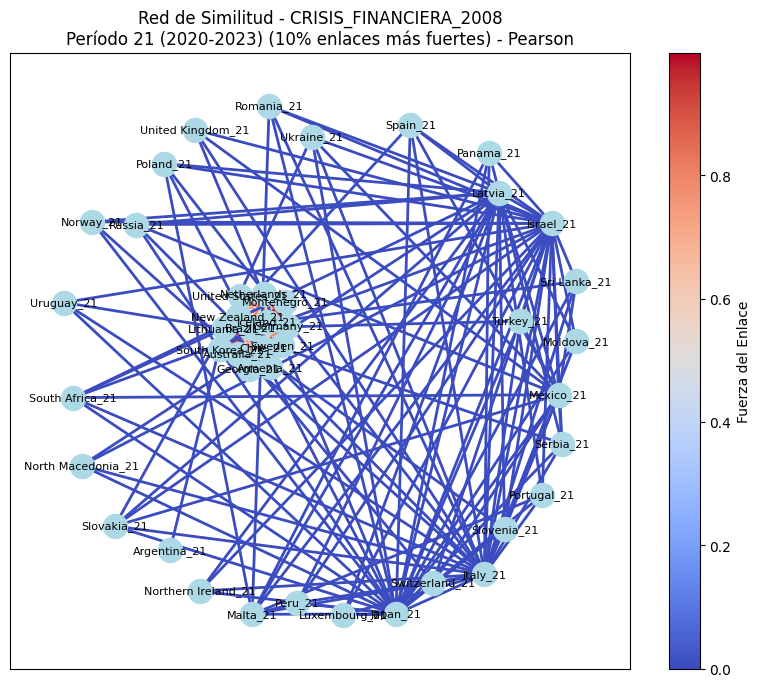

Se identificaron 31 clusters para el aspecto 'CRISIS_FINANCIERA_2008'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3208186923.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


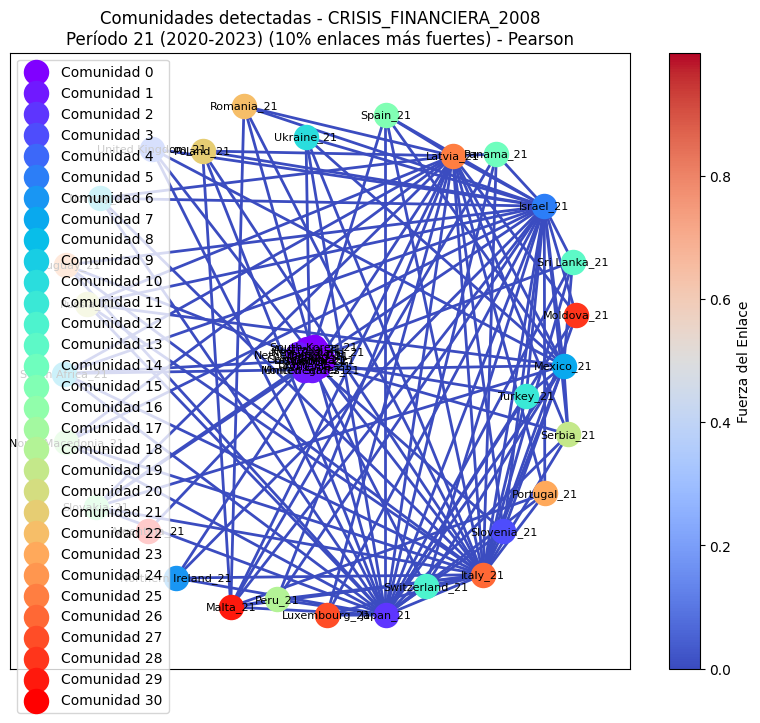

Chile pertenece a la Comunidad 0, que incluye 9 países:
['Armenia_21', 'Australia_21', 'Chile_21', 'Georgia_21', 'Iceland_21', 'Lithuania_21', 'New Zealand_21', 'South Korea_21', 'Sweden_21']
Comunidad 1 incluye 5 países:
['Brazil_21', 'Germany_21', 'Montenegro_21', 'Netherlands_21', 'United States_21']
Comunidad 2 incluye 1 países:
['Japan_21']
Comunidad 3 incluye 1 países:
['Slovenia_21']
Comunidad 4 incluye 1 países:
['United Kingdom_21']
Comunidad 5 incluye 1 países:
['Israel_21']
Comunidad 6 incluye 1 países:
['Northern Ireland_21']
Comunidad 7 incluye 1 países:
['Mexico_21']
Comunidad 8 incluye 1 países:
['South Africa_21']
Comunidad 9 incluye 1 países:
['Norway_21']
Comunidad 10 incluye 1 países:
['Ukraine_21']
Comunidad 11 incluye 1 países:
['Turkey_21']
Comunidad 12 incluye 1 países:
['Switzerland_21']
Comunidad 13 incluye 1 países:
['Sri Lanka_21']
Comunidad 14 incluye 1 países:
['Panama_21']
Comunidad 15 incluye 1 países:
['Spain_21']
Comunidad 16 incluye 1 países:
['Slovaki

Nodo  Betweenness_Centrality  Degree_Centrality  \
17            Israel_21           947548.080801           0.642857   
14             Japan_21           778747.850451           0.642857   
37            Latvia_21           466868.840128           0.500000   
38             Italy_21           250880.283520           0.642857   
19            Mexico_21            59038.186833           0.357143   
5          Lithuania_21              189.563325           0.571429   
28          Slovakia_21                1.707788           0.142857   
31            Serbia_21                1.703391           0.142857   
41             Malta_21                0.845730           0.214286   
15          Slovenia_21                0.654124           0.142857   
20      South Africa_21                0.502699           0.142857   
27             Spain_21                0.478629           0.142857   
25         Sri Lanka_21                0.234418           0.119048   
22           Ukraine_21                0.201252           0.119048   
23            Turkey_21                0.194031           0.119048   
24       Switzerland_21                0.193069           0.119048   
36           Uruguay_21                0.142986           0.095238   
35          Portugal_21                0.136835           0.119048   
30              Peru_21                0.108814           0.119048   
33            Poland_21                0.108755           0.119048   
34           Romania_21                0.077228           0.119048   
26            Panama_21                0.070517           0.119048   
32            Russia_21                0.054975           0.119048   
16    United Kingdom_21                0.050713           0.095238   
21            Norway_21                0.016463           0.095238   
29   North Macedonia_21                0.008830           0.095238   
18  Northern Ireland_21                0.008770           0.095238   
39        Luxembourg_21                0.006540           0.095238   
40           Moldova_21                0.005660           0.095238   
9         Montenegro_21                0.004646           0.309524   
3        South Korea_21                0.002323           0.309524   
12       Netherlands_21                0.001161           0.309524   
0        New Zealand_21                0.000000           0.309524   
1             Sweden_21                0.000000           0.309524   
13             Chile_21                0.000000           0.309524   
11           Germany_21                0.000000           0.309524   
10           Georgia_21                0.000000           0.309524   
8      United States_21                0.000000           0.309524   
7             Brazil_21                0.000000           0.309524   
6            Armenia_21                0.000000           0.309524   
4            Iceland_21                0.000000           0.309524   
2          Australia_21                0.000000           0.309524   
42         Argentina_21                0.000000           0.023810   

    Closeness_Centrality  
17              0.591549  
14              0.591549  
37              0.545455  
38              0.591549  
19              0.506024  
5               0.575342  
28              0.538462  
31              0.538462  
41              0.403846  
15              0.538462  
20              0.538462  
27              0.538462  
25              0.531646  
22              0.531646  
23              0.531646  
24              0.531646  
36              0.525000  
35              0.388889  
30              0.388889  
33              0.388889  
34              0.388889  
26              0.388889  
32              0.388889  
16              0.385321  
21              0.385321  
29              0.385321  
18              0.385321  
39              0.385321  
40              0.385321  
9               0.411765  
3               0.411765  
12              0.411765  
0               0.411765  
1               0.41

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3208186923.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3208186923.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


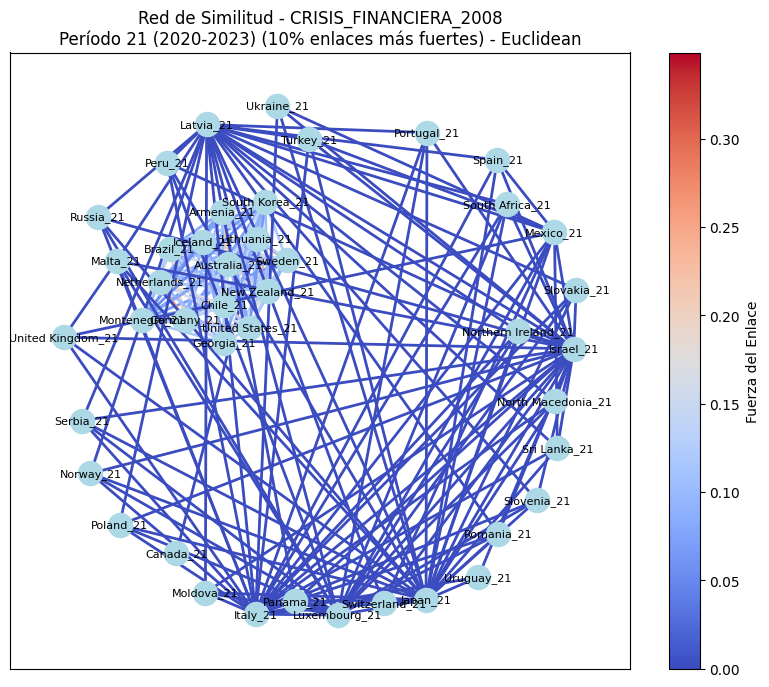

Se identificaron 31 clusters para el aspecto 'CRISIS_FINANCIERA_2008'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3208186923.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


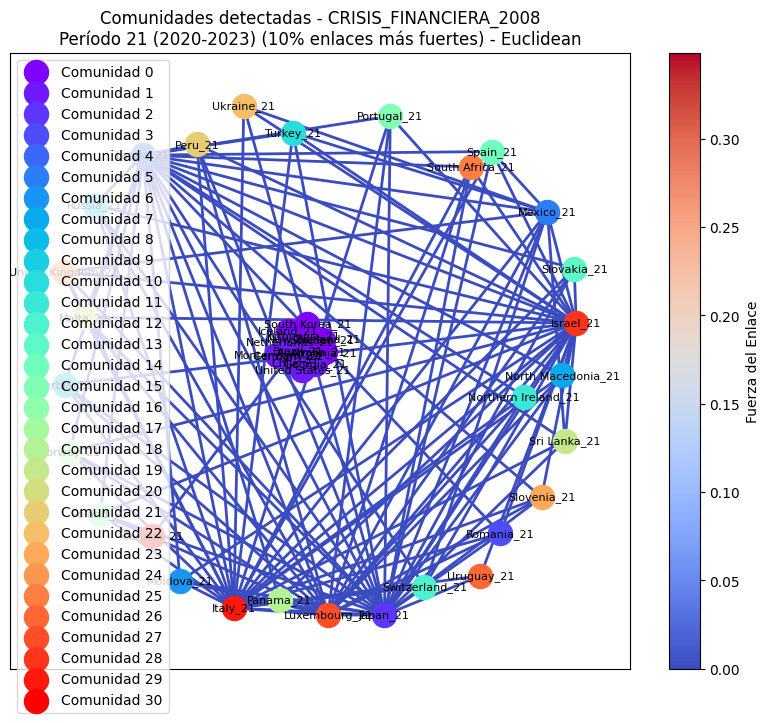

Chile pertenece a la Comunidad 1, que incluye 7 países:
['Brazil_21', 'Chile_21', 'Georgia_21', 'Germany_21', 'Montenegro_21', 'Netherlands_21', 'United States_21']
Comunidad 0 incluye 7 países:
['Armenia_21', 'Australia_21', 'Iceland_21', 'Lithuania_21', 'New Zealand_21', 'South Korea_21', 'Sweden_21']
Comunidad 2 incluye 1 países:
['Japan_21']
Comunidad 3 incluye 1 países:
['Romania_21']
Comunidad 4 incluye 1 países:
['Latvia_21']
Comunidad 5 incluye 1 países:
['Mexico_21']
Comunidad 6 incluye 1 países:
['Moldova_21']
Comunidad 7 incluye 1 países:
['North Macedonia_21']
Comunidad 8 incluye 1 países:
['Serbia_21']
Comunidad 9 incluye 1 países:
['Russia_21']
Comunidad 10 incluye 1 países:
['Turkey_21']
Comunidad 11 incluye 1 países:
['Northern Ireland_21']
Comunidad 12 incluye 1 países:
['Switzerland_21']
Comunidad 13 incluye 1 países:
['Slovakia_21']
Comunidad 14 incluye 1 países:
['Spain_21']
Comunidad 15 incluye 1 países:
['Portugal_21']
Comunidad 16 incluye 1 países:
['Poland_21']


Nodo  Betweenness_Centrality  Degree_Centrality  \
14             Japan_21           701577.666022           0.642857   
16            Latvia_21           333304.557340           0.571429   
40            Israel_21           326631.837001           0.642857   
41             Italy_21           175081.326237           0.642857   
39        Luxembourg_21            58630.128054           0.476190   
17            Mexico_21             1721.248333           0.261905   
32             Malta_21               50.220475           0.142857   
36    United Kingdom_21                4.061847           0.119048   
20            Serbia_21                0.119677           0.119048   
37      South Africa_21                0.119618           0.119048   
35          Slovenia_21                0.119589           0.119048   
33              Peru_21                0.119575           0.119048   
25          Slovakia_21                0.119571           0.119048   
21            Russia_21                0.119558           0.119048   
27          Portugal_21                0.119557           0.119048   
15           Romania_21                0.119556           0.119048   
28            Poland_21                0.105015           0.119048   
30            Panama_21                0.060310           0.119048   
26             Spain_21                0.057353           0.119048   
31         Sri Lanka_21                0.051424           0.119048   
24       Switzerland_21                0.050881           0.119048   
22            Turkey_21                0.050847           0.119048   
18           Moldova_21                0.041789           0.119048   
19   North Macedonia_21                0.041610           0.119048   
23  Northern Ireland_21                0.041521           0.119048   
29            Norway_21                0.041477           0.119048   
0          Lithuania_21                0.022648           0.333333   
13        Montenegro_21                0.022648           0.309524   
34           Ukraine_21                0.019566           0.095238   
12       South Korea_21                0.010453           0.309524   
38           Uruguay_21                0.002196           0.071429   
1             Sweden_21                0.000000           0.309524   
11           Iceland_21                0.000000           0.309524   
10           Georgia_21                0.000000           0.309524   
9              Chile_21                0.000000           0.309524   
8            Armenia_21                0.000000           0.309524   
7          Australia_21                0.000000           0.309524   
6      United States_21                0.000000           0.309524   
5             Brazil_21                0.000000           0.309524   
4        New Zealand_21                0.000000           0.309524   
3        Netherlands_21                0.000000           0.309524   
2            Germany_21                0.000000           0.309524   
42            Canada_21                0.000000           0.023810   

    Closeness_Centrality  
14              0.642857  
16              0.578571  
40              0.642857  
41              0.642857  
39              0.510504  
17              0.403654  
32              0.361607  
36              0.354227  
20              0.354227  
37              0.354227  
35              0.354227  
33              0.354227  
25              0.354227  
21              0.354227  
27              0.354227  
15              0.354227  
28              0.354227  
30              0.354227  
26              0.354227  
31              0.354227  
24              0.354227  
22              0.354227  
18              0.354227  
19              0.354227  
23              0.354227  
29              0.354227  
0               0.333333  
13              0.311111  
34              0.347143  
12              0.311111  
38              0.340336  
1               0.311111  
11              0.311111  
10              0.31


=== Análisis para el aspecto: INMIGRANTES ===



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3208186923.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3208186923.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


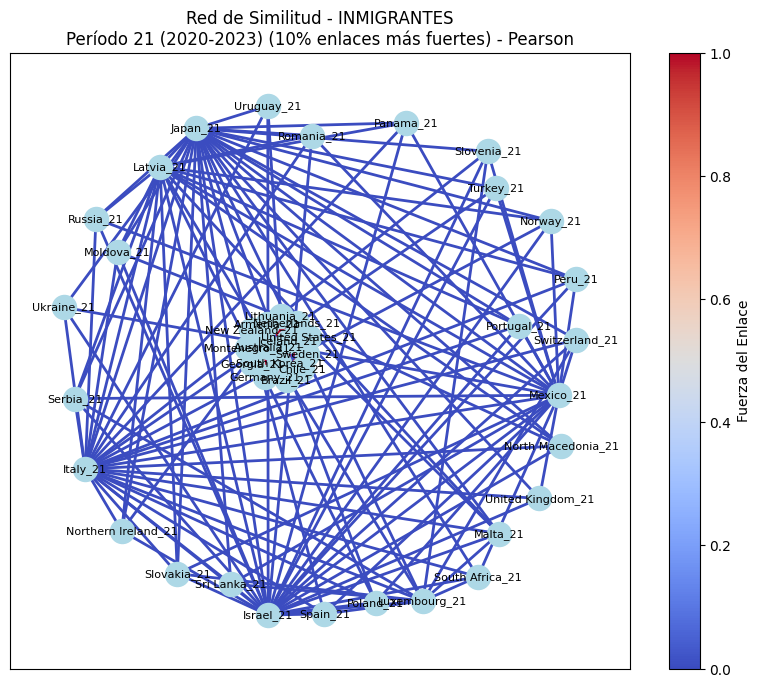

Se identificaron 29 clusters para el aspecto 'INMIGRANTES'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3208186923.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


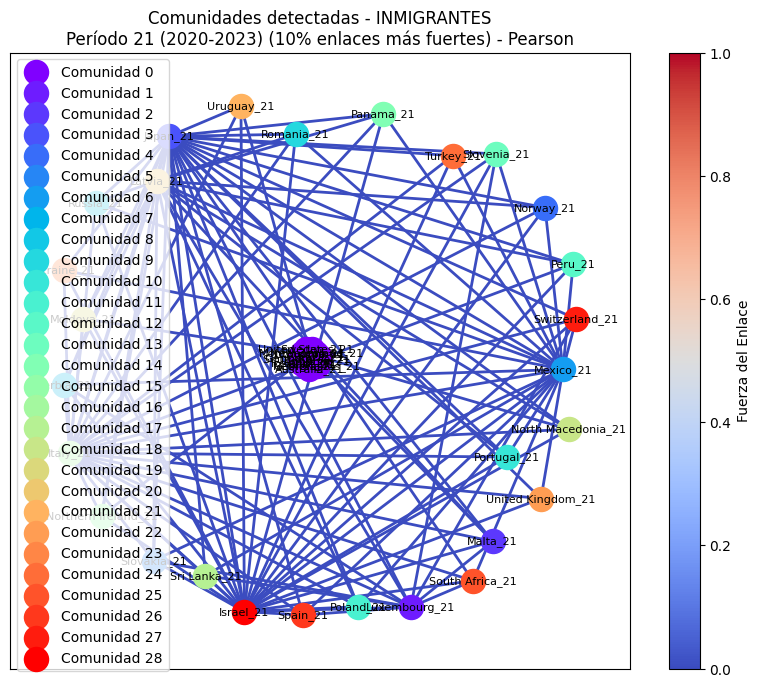

Chile pertenece a la Comunidad 0, que incluye 14 países:
['Armenia_21', 'Australia_21', 'Brazil_21', 'Chile_21', 'Georgia_21', 'Germany_21', 'Iceland_21', 'Lithuania_21', 'Montenegro_21', 'Netherlands_21', 'New Zealand_21', 'South Korea_21', 'Sweden_21', 'United States_21']
Comunidad 1 incluye 1 países:
['Luxembourg_21']
Comunidad 2 incluye 1 países:
['Malta_21']
Comunidad 3 incluye 1 países:
['Japan_21']
Comunidad 4 incluye 1 países:
['Norway_21']
Comunidad 5 incluye 1 países:
['Slovakia_21']
Comunidad 6 incluye 1 países:
['Mexico_21']
Comunidad 7 incluye 1 países:
['Serbia_21']
Comunidad 8 incluye 1 países:
['Russia_21']
Comunidad 9 incluye 1 países:
['Romania_21']
Comunidad 10 incluye 1 países:
['Portugal_21']
Comunidad 11 incluye 1 países:
['Poland_21']
Comunidad 12 incluye 1 países:
['Peru_21']
Comunidad 13 incluye 1 países:
['Slovenia_21']
Comunidad 14 incluye 1 países:
['Panama_21']
Comunidad 15 incluye 1 países:
['Northern Ireland_21']
Comunidad 16 incluye 1 países:
['Italy_21'

Nodo  Betweenness_Centrality  Degree_Centrality  \
16             Japan_21           792076.469105           0.658537   
19            Mexico_21           262833.614159           0.512195   
29             Italy_21           179195.221386           0.658537   
41            Israel_21           149449.764468           0.658537   
14        Luxembourg_21             2126.279442           0.292683   
33            Latvia_21             1959.211183           0.439024   
0          Lithuania_21                1.968845           0.439024   
15             Malta_21                1.115260           0.146341   
20            Serbia_21                0.821181           0.146341   
18          Slovakia_21                0.821175           0.146341   
26          Slovenia_21                0.661981           0.121951   
32           Moldova_21                0.652112           0.121951   
31   North Macedonia_21                0.644672           0.121951   
28  Northern Ireland_21                0.640963           0.121951   
34           Uruguay_21                0.521610           0.097561   
38      South Africa_21                0.168824           0.121951   
30         Sri Lanka_21                0.152024           0.121951   
40       Switzerland_21                0.151989           0.121951   
39             Spain_21                0.151871           0.121951   
37            Turkey_21                0.126205           0.097561   
35    United Kingdom_21                0.112414           0.097561   
36           Ukraine_21                0.111922           0.097561   
27            Panama_21                0.110767           0.121951   
25              Peru_21                0.110216           0.121951   
24            Poland_21                0.109981           0.121951   
21            Russia_21                0.109838           0.121951   
17            Norway_21                0.085812           0.121951   
23          Portugal_21                0.083774           0.121951   
22           Romania_21                0.083704           0.121951   
8            Iceland_21                0.000000           0.317073   
3         Montenegro_21                0.000000           0.317073   
1      United States_21                0.000000           0.317073   
4        Netherlands_21                0.000000           0.317073   
2            Germany_21                0.000000           0.317073   
5        New Zealand_21                0.000000           0.317073   
6              Chile_21                0.000000           0.317073   
13         Australia_21                0.000000           0.317073   
12           Armenia_21                0.000000           0.317073   
11       South Korea_21                0.000000           0.317073   
10            Brazil_21                0.000000           0.317073   
9             Sweden_21                0.000000           0.317073   
7            Georgia_21                0.000000           0.317073   

    Closeness_Centrality  
16              0.602941  
19              0.465909  
29              0.602941  
41              0.602941  
14              0.493976  
33              0.532468  
0               0.500000  
15              0.539474  
20              0.398058  
18              0.398058  
26              0.394231  
32              0.532468  
31              0.532468  
28              0.532468  
34              0.525641  
38              0.394231  
30              0.394231  
40              0.394231  
39              0.394231  
37              0.390476  
35              0.390476  
36              0.390476  
27              0.394231  
25              0.394231  
24              0.394231  
21              0.394231  
17              0.394231  
23              0.394231  
22              0.394231  
8               0.372727  
3               0.372727  
1               0.372727  
4               0.372727  
2               0.372727  
5               0.372727  
6               0.372727  
13       

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3208186923.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3208186923.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


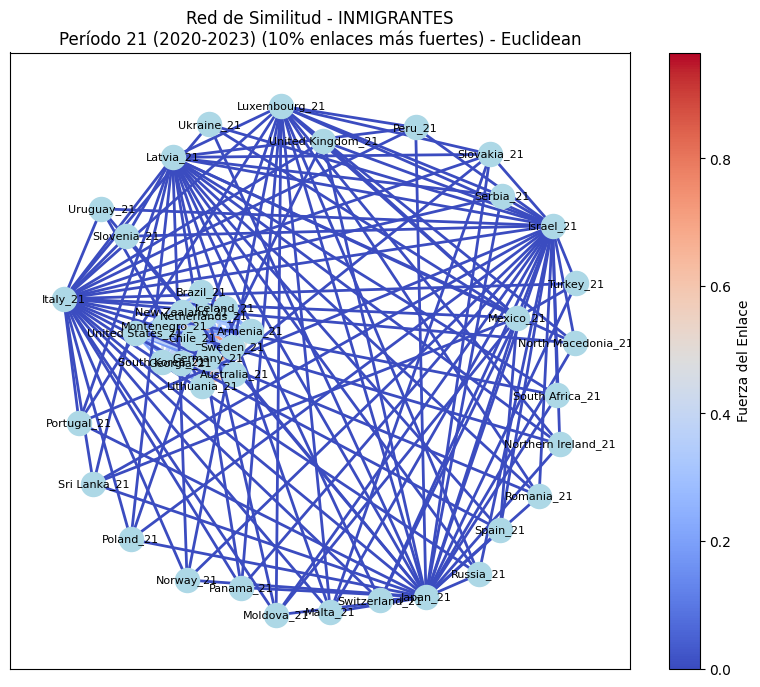

Se identificaron 30 clusters para el aspecto 'INMIGRANTES'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3208186923.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


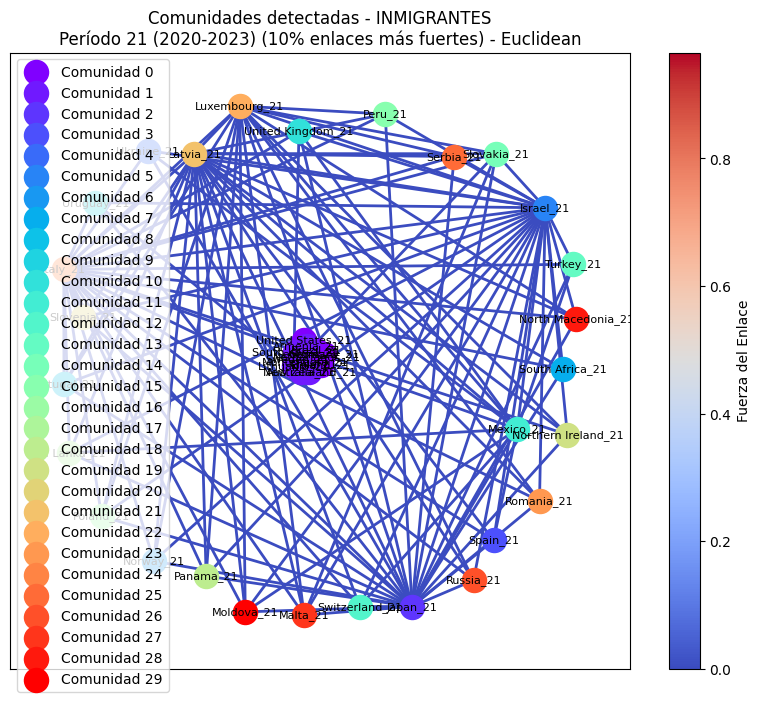

Chile pertenece a la Comunidad 0, que incluye 8 países:
['Brazil_21', 'Chile_21', 'Georgia_21', 'Germany_21', 'Iceland_21', 'Montenegro_21', 'Netherlands_21', 'United States_21']
Comunidad 1 incluye 6 países:
['Armenia_21', 'Australia_21', 'Lithuania_21', 'New Zealand_21', 'South Korea_21', 'Sweden_21']
Comunidad 2 incluye 1 países:
['Japan_21']
Comunidad 3 incluye 1 países:
['Spain_21']
Comunidad 4 incluye 1 países:
['Ukraine_21']
Comunidad 5 incluye 1 países:
['Israel_21']
Comunidad 6 incluye 1 países:
['Norway_21']
Comunidad 7 incluye 1 países:
['South Africa_21']
Comunidad 8 incluye 1 países:
['Portugal_21']
Comunidad 9 incluye 1 países:
['Uruguay_21']
Comunidad 10 incluye 1 países:
['United Kingdom_21']
Comunidad 11 incluye 1 países:
['Mexico_21']
Comunidad 12 incluye 1 países:
['Switzerland_21']
Comunidad 13 incluye 1 países:
['Turkey_21']
Comunidad 14 incluye 1 países:
['Slovakia_21']
Comunidad 15 incluye 1 países:
['Peru_21']
Comunidad 16 incluye 1 países:
['Poland_21']
Comunid

Nodo  Betweenness_Centrality  Degree_Centrality  \
17            Israel_21           990171.039050           0.658537   
14             Japan_21           919817.484606           0.658537   
33            Latvia_21           578601.733980           0.560976   
36             Italy_21           460201.862483           0.658537   
23            Mexico_21           136750.305235           0.292683   
34        Luxembourg_21            13162.721985           0.439024   
26          Slovakia_21             5714.857414           0.170732   
22    United Kingdom_21             2074.288794           0.121951   
21           Uruguay_21               46.243261           0.097561   
15             Spain_21                0.488069           0.121951   
29         Sri Lanka_21                0.418678           0.121951   
24       Switzerland_21                0.416317           0.121951   
25            Turkey_21                0.298846           0.097561   
16           Ukraine_21                0.297570           0.097561   
7          Lithuania_21                0.239881           0.390244   
32          Slovenia_21                0.154327           0.097561   
19      South Africa_21                0.154326           0.097561   
39             Malta_21                0.099282           0.146341   
37            Serbia_21                0.085943           0.121951   
35           Romania_21                0.085943           0.121951   
13     United States_21                0.085849           0.317073   
41           Moldova_21                0.063822           0.146341   
18            Norway_21                0.047003           0.121951   
38            Russia_21                0.044485           0.121951   
31  Northern Ireland_21                0.028843           0.121951   
30            Panama_21                0.028761           0.121951   
27              Peru_21                0.028722           0.121951   
28            Poland_21                0.028705           0.121951   
20          Portugal_21                0.028694           0.121951   
40   North Macedonia_21                0.026471           0.121951   
12           Armenia_21                0.015854           0.317073   
1            Iceland_21                0.000000           0.317073   
4        Netherlands_21                0.000000           0.317073   
2            Georgia_21                0.000000           0.317073   
3         Montenegro_21                0.000000           0.317073   
9          Australia_21                0.000000           0.317073   
5        New Zealand_21                0.000000           0.317073   
6             Sweden_21                0.000000           0.317073   
8              Chile_21                0.000000           0.317073   
10           Germany_21                0.000000           0.317073   
11       South Korea_21                0.000000           0.317073   
0             Brazil_21                0.000000           0.317073   

    Closeness_Centrality  
17              0.602941  
14              0.602941  
33              0.569444  
36              0.602941  
23              0.493976  
34              0.532468  
26              0.546667  
22              0.532468  
21              0.525641  
15              0.394231  
29              0.394231  
24              0.394231  
25              0.390476  
16              0.390476  
7               0.488095  
32              0.390476  
19              0.390476  
39              0.460674  
37              0.394231  
35              0.394231  
13              0.366071  
41              0.398058  
18              0.394231  
38              0.394231  
31              0.394231  
30              0.394231  
27              0.394231  
28              0.394231  
20              0.394231  
40              0.394231  
12              0.366071  
1               0.366071  
4               0.366071  
2               0.366071  
3               0.366071  
9               0.366071  
5        




RESUMEN DE CENTRALIDADES
ASPECTO: INMIGRANTES
PERÍODO: 21


Aspecto   Criterio  Num_Comunidades  Comunidad_Chile  \
0  CRISIS_FINANCIERA_2008    Pearson               31                0   
1  CRISIS_FINANCIERA_2008  Euclidean               31                1   
2             INMIGRANTES    Pearson               29                0   
3             INMIGRANTES  Euclidean               30                0   

   Num_Paises_Chile_Comunidad  Num_Paises  Promedio_Degree_Centrality  \
0                           9          43                      0.2370   
1                           7          43                      0.2370   
2                          14          42                      0.2485   
3                           8          42                      0.2485   

   Std_Degree_Centrality  Max_Degree_Centrality  \
0                 0.1639                 0.6429   
1                 0.1624                 0.6429   
2                 0.1617                 0.6585   
3                 0.1628                 0.6585   

   Promedio_Betweenness_Centrality  Std_Betweenness_Centrality  \
0                       58215.8215                 197782.8314   
1                       37139.5959                 127687.6213   
2                       33039.2875                 131137.0714   
3                       73965.3263                 229644.6333   

   Max_Betweenness_Centrality  Promedio_Closeness_Centrality  \
0                 947548.0808                         0.4539   
1                 701577.6660                         0.3663   
2                 792076.4691                         0.4287   
3                 990171.0391                         0.4239   

   Std_Closeness_Centrality  Max_Closeness_Centrality  \
0                    0.0747                    0.5915   
1                    0.0949                    0.6429   
2                    0.0745                    0.6029   
3                    0.0760                    0.6029   

   Promedio_Eigenvector_Centrality  Std_Eigenvector_Centrality  \
0                           0.1140                      0.1025   
1                           0.0875                      0.1264   
2                           0.1064                      0.1131   
3                           0.1025                      0.1167   

   Max_Eigenvector_Centrality  
0                      0.2918  
1                      0.2686  
2                      0.2759  
3                      0.2718

In [23]:
# Parámetros de ejecución
periodo = 21
porcentaje = 10
pearsonsino = True  # Cambiar a False para omitir el análisis de Pearson

# Lista para almacenar los resúmenes
resumen_aspectos = []

# Iterar sobre todos los aspectos en el DataFrame df_aspectos
for aspecto in df_aspectos['aspecto']:
    print(f"\n=== Análisis para el aspecto: {aspecto} ===\n")
    
    if pearsonsino:
        # Calcular similitudes usando Pearson
        df_similarity_pearson = calcular_similitudes_todos_paises(
            df_5_extended, 
            df_aspectos[df_aspectos['aspecto'] == aspecto], 
            tipo_similitud='pearson', 
            periodo=periodo
        )
        resumen_pearson, _ = generar_red_y_calcular_metricas(
            df_similarity_pearson, 
            aspecto=aspecto, 
            tipo_similitud='Pearson', 
            porcentaje=porcentaje, 
            periodo=periodo
        )
        resumen_aspectos.append(resumen_pearson)
    
    # Calcular similitudes usando Euclidean
    df_similarity_euclidean = calcular_similitudes_todos_paises(
        df_5_extended, 
        df_aspectos[df_aspectos['aspecto'] == aspecto], 
        tipo_similitud='euclidean', 
        periodo=periodo
    )
    resumen_euclidean, _ = generar_red_y_calcular_metricas(
        df_similarity_euclidean, 
        aspecto=aspecto, 
        tipo_similitud='Euclidean', 
        porcentaje=porcentaje, 
        periodo=periodo
    )
    resumen_aspectos.append(resumen_euclidean)

# Crear el DataFrame resumen
df_resumen = pd.DataFrame(resumen_aspectos)

print("\n\n\nRESUMEN DE CENTRALIDADES")
print(f"ASPECTO: {aspecto}")
print(f"PERÍODO: {periodo}")
# Mostrar el resumen
display(df_resumen)


##### ANÁLISIS DEL ASPECTO: 'CRISIS_FINANCIERA_2008' en el período 21: 
* 

#### VEAMOS CÓMO SE DISTRIBUYEN LAS MÉTRICAS DE CENTRALIDAD PARA VER SI HAY NODOS QUE MUESTREN EXCEPCIONALIDADES


=== Distribución de centralidades para el aspecto: CRISIS_FINANCIERA_2008 ===



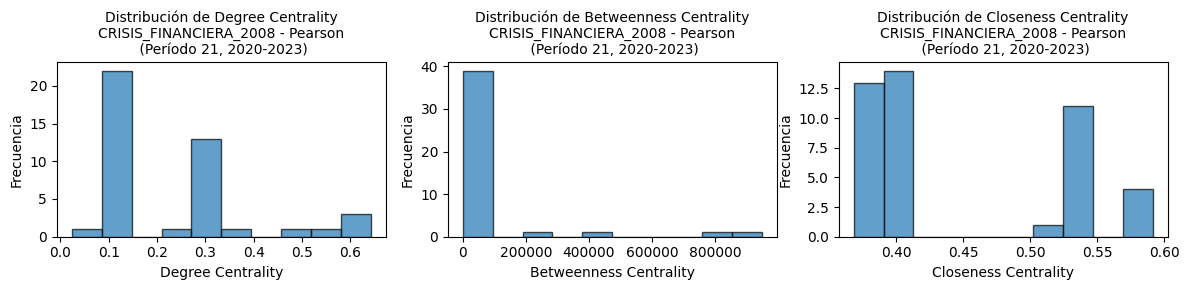

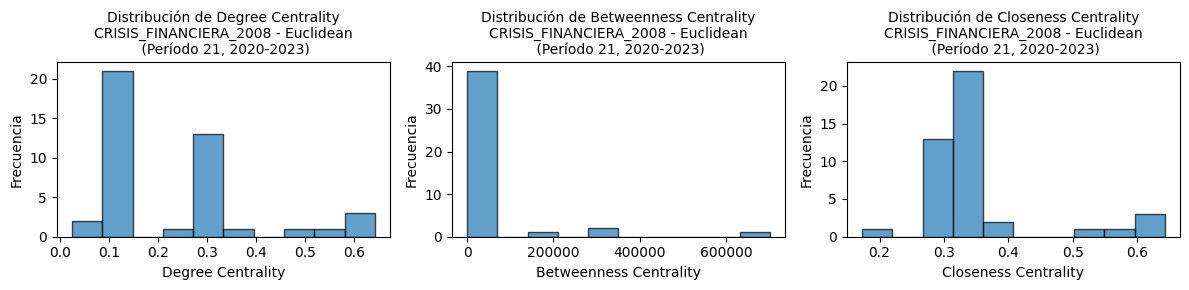


=== Distribución de centralidades para el aspecto: INMIGRANTES ===



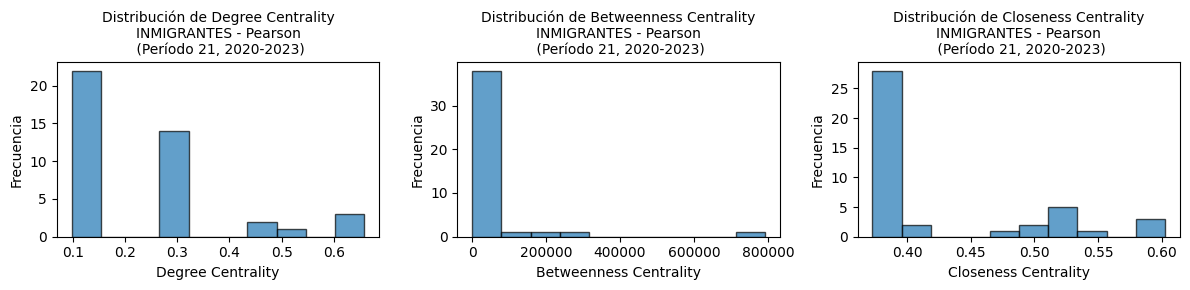

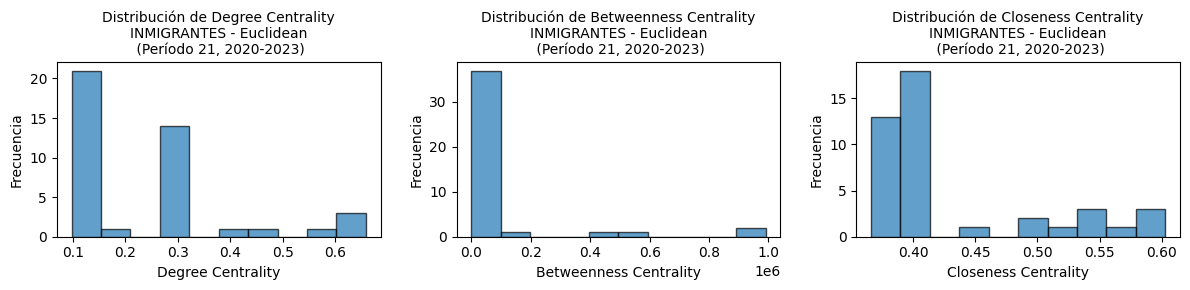

In [24]:
import matplotlib.pyplot as plt

def calcular_centralidades(df_similarity, aspecto, tipo_similitud, porcentaje, periodo):
    """
    Calcula las métricas de centralidad para un grafo construido a partir de las similitudes.
    """
    # Filtrar los x% enlaces con mayor similaridad
    df_similarity = df_similarity.sort_values(by='Similarity', ascending=False)
    top_x_percent = int(len(df_similarity) * (porcentaje / 100))
    df_top_similarity = df_similarity.head(top_x_percent)

    # Crear el grafo
    G = nx.Graph()
    for _, row in df_top_similarity.iterrows():
        nodo_1 = row['Country_Period_1']
        nodo_2 = row['Country_Period_2']
        G.add_edge(nodo_1, nodo_2, weight=row['Similarity'])

    # Calcular métricas de centralidad
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    # Resumen de centralidades
    centralities = pd.DataFrame({
        'Nodo': list(degree.keys()),
        'Degree_Centrality': list(degree.values()),
        'Betweenness_Centrality': list(betweenness.values()),
        'Closeness_Centrality': list(closeness.values()),
        'Eigenvector_Centrality': list(eigenvector.values())
    })

    return centralities


def graficar_distribucion_centralidades(df_centralities, aspecto, tipo_similitud, periodo, titulo_fontsize=10):
    """Grafica la distribución de las centralidades para un aspecto específico."""
    # Obtener los años "Desde" y "Hasta" para el período
    desde_hasta_df = df_ventana_5[df_ventana_5['ventana'] == periodo]
    desde = desde_hasta_df['agno'].min()
    hasta = desde_hasta_df['agno'].max()

    metrics = ['Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality']
    num_metrics = len(metrics)
    
    plt.figure(figsize=(12, 3))
    for i, metric in enumerate(metrics):
        plt.subplot(1, num_metrics, i + 1)
        plt.hist(df_centralities[metric], bins=10, edgecolor='black', alpha=0.7)
        plt.title(f'Distribución de {metric.replace("_", " ")}\n{aspecto} - {tipo_similitud}\n (Período {periodo}, {desde}-{hasta})', fontsize=titulo_fontsize)
        plt.xlabel(metric.replace("_", " "))
        plt.ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()


# Ejecución para graficar distribuciones
for aspecto in df_aspectos['aspecto']:
    print(f"\n=== Distribución de centralidades para el aspecto: {aspecto} ===\n")
    
    if pearsonsino:
        df_similarity_pearson = calcular_similitudes_todos_paises(
            df_5_extended, 
            df_aspectos[df_aspectos['aspecto'] == aspecto], 
            tipo_similitud='pearson', 
            periodo=periodo
        )
        centralities_pearson = calcular_centralidades(
            df_similarity_pearson, 
            aspecto=aspecto, 
            tipo_similitud='Pearson', 
            porcentaje=porcentaje, 
            periodo=periodo
        )
        graficar_distribucion_centralidades(centralities_pearson, aspecto, 'Pearson', periodo, titulo_fontsize=10)
    
    df_similarity_euclidean = calcular_similitudes_todos_paises(
        df_5_extended, 
        df_aspectos[df_aspectos['aspecto'] == aspecto], 
        tipo_similitud='euclidean', 
        periodo=periodo
    )
    centralities_euclidean = calcular_centralidades(
        df_similarity_euclidean, 
        aspecto=aspecto, 
        tipo_similitud='Euclidean', 
        porcentaje=porcentaje, 
        periodo=periodo
    )
    graficar_distribucion_centralidades(centralities_euclidean, aspecto, 'Euclidean', periodo, titulo_fontsize=10)


In [25]:
df_similarity_euclidean

Country_Period_1   Country_Period_2  Similarity
0           Albania_21       Argentina_21         0.0
1           Albania_21         Austria_21         0.0
2           Albania_21      Azerbaijan_21         0.0
3           Albania_21         Belarus_21         0.0
4           Albania_21         Belgium_21         0.0
...                ...                ...         ...
2140  United States_21     Switzerland_21         0.0
2141  United States_21          Turkey_21         0.0
2142  United States_21         Ukraine_21         0.0
2143  United States_21  United Kingdom_21         0.0
2144  United States_21         Uruguay_21         0.0

[2145 rows x 3 columns]

In [26]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()

Dominio      Nombre_Dominio Variable_per  \
0  Domain_1  External Relations       per101   
1  Domain_1  External Relations       per102   
2  Domain_1  External Relations       per103   
3  Domain_1  External Relations       per104   
4  Domain_1  External Relations       per105   

                           Detalle_Dominio  
0  Foreign Special Relationships: Positive  
1  Foreign Special Relationships: Negative  
2                         Anti-Imperialism  
3                       Military: Positive  
4                       Military: Negative

#### Analicemos 'Democracia_o_Autoritario' sólo con dos variables ya que la tercera es menos informada. Chile aparece en rojo

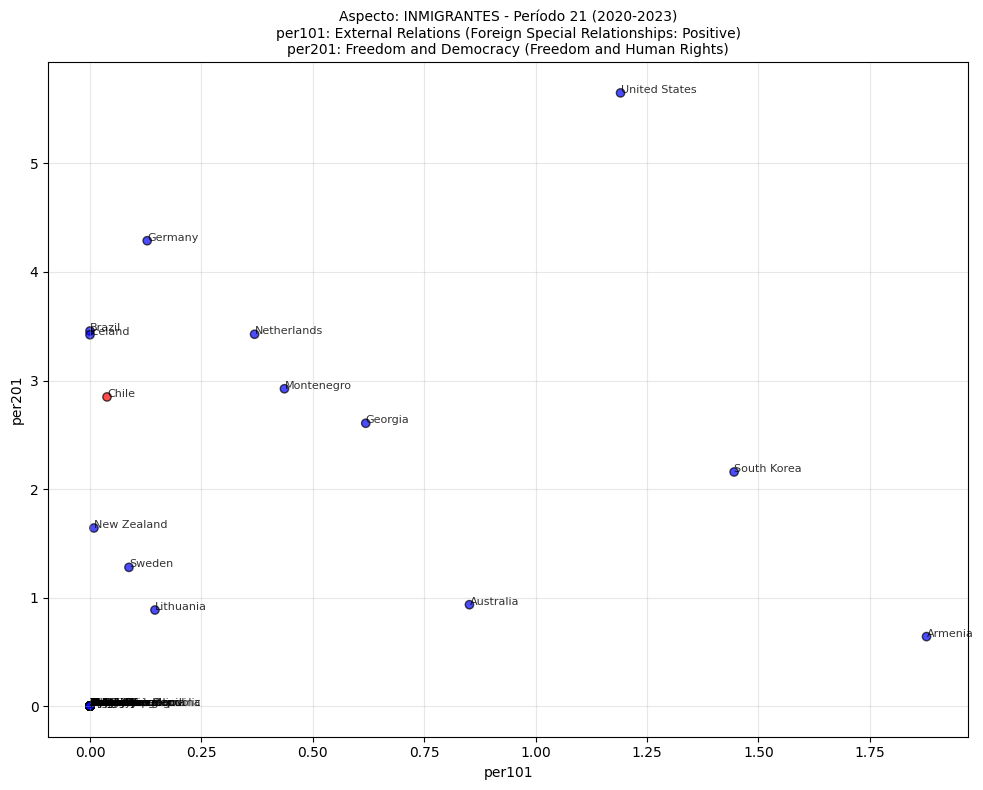

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5753/3866549012.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_data.rename(columns={'countryname': 'País'}, inplace=True)


País  per101  per201
13           Armenia  1.8774  0.6402
29         Australia  0.8516  0.9341
75            Brazil  0.0000  3.4564
102            Chile  0.0382  2.8487
180          Georgia  0.6189  2.6060
...              ...     ...     ...
1336     Switzerland  0.0000  0.0000
1343          Turkey  0.0000  0.0000
1359         Ukraine  0.0000  0.0000
1365  United Kingdom  0.0000  0.0000
1385         Uruguay  0.0000  0.0000

[66 rows x 3 columns]

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar las variables asociadas al aspecto 'Democracia_o_Autoritario'
aspecto_filtro = 'INMIGRANTES'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2']].dropna().values.flatten()

# Obtener los dominios y detalles asociados a las variables
df_variables_info = df_AD[df_AD['Variable_per'].isin(variables)][['Variable_per', 'Nombre_Dominio', 'Detalle_Dominio']]

# Crear la descripción del título con las variables y sus dominios
variables_descripcion = "\n".join([
    f"{row['Variable_per']}: {row['Nombre_Dominio']} ({row['Detalle_Dominio']})"
    for _, row in df_variables_info.iterrows()
])

# Filtrar el dataframe con las variables seleccionadas
df_filtered = df_5_extended[['countryname', 'ventana_5'] + list(variables)].copy()
df_filtered = df_filtered[df_filtered['ventana_5'] == periodo]  # Filtrar por el período deseado

# Obtener los años "Desde" y "Hasta" para el período
desde_hasta_df = df_ventana_5[df_ventana_5['ventana'] == periodo]
desde = desde_hasta_df['agno'].min()
hasta = desde_hasta_df['agno'].max()

# Redondear los valores a 4 decimales
df_filtered[list(variables)] = df_filtered[list(variables)].round(4)

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 8))

# Asignar colores: rojo para Chile, azul para otros países
colors = ['red' if country == 'Chile' else 'blue' for country in df_filtered['countryname']]
plt.scatter(df_filtered[variables[0]], df_filtered[variables[1]], c=colors, alpha=0.7, edgecolor='k')

# Añadir etiquetas para los puntos
for i, row in df_filtered.iterrows():
    plt.text(row[variables[0]], row[variables[1]], row['countryname'], fontsize=8, alpha=0.8)

# Configurar título y etiquetas
plt.title(
    f'Aspecto: {aspecto_filtro} - Período {periodo} ({desde}-{hasta})\n{variables_descripcion}', 
    fontsize=10
)
plt.xlabel(variables[0].replace('_', ' '), fontsize=10)
plt.ylabel(variables[1].replace('_', ' '), fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Preparar la tabla como DataFrame filtrada por período
table_data = df_filtered[['countryname'] + list(variables)]
table_data.rename(columns={'countryname': 'País'}, inplace=True)

# Mostrar la tabla
table_data


#### Analicemos la dispersión de un aspecto descrito por 3 variables: 

In [28]:
df_aspectos

aspecto   var_1   var_2   var_3   var_4
0  CRISIS_FINANCIERA_2008  per401  per403  per503  per504
1             INMIGRANTES  per101  per201    None    None

TypeError: text() missing 1 required positional argument: 's'

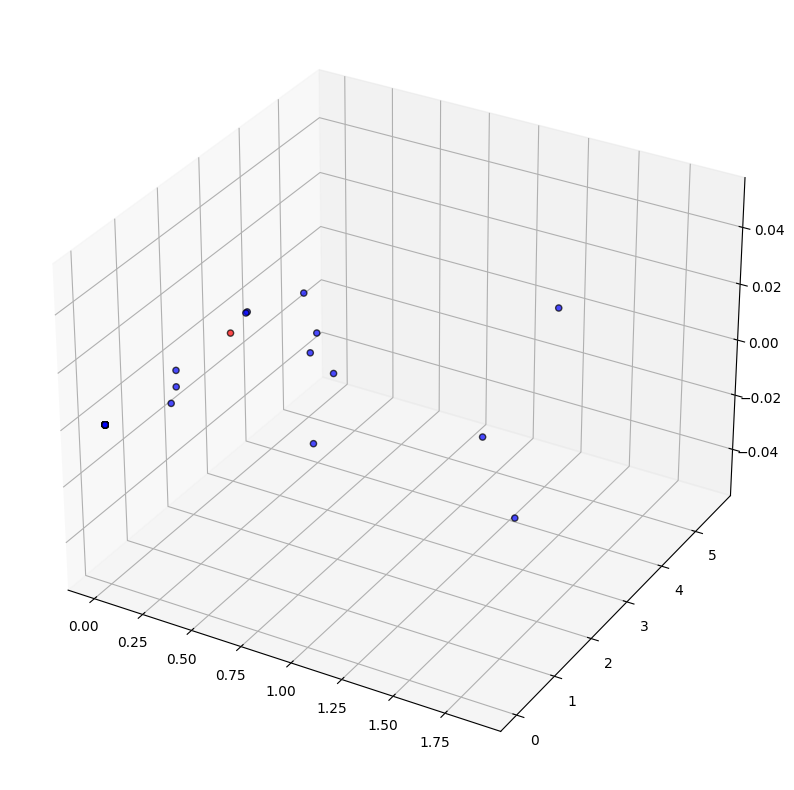

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Filtrar las variables asociadas al aspecto
aspecto_filtro = 'INMIGRANTES'  # Cambiar al aspecto deseado
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2']].dropna().values.flatten()

# Obtener los dominios y detalles asociados a las variables
df_variables_info = df_AD[df_AD['Variable_per'].isin(variables)][['Variable_per', 'Nombre_Dominio', 'Detalle_Dominio']]

# Crear la descripción del título con las variables y sus dominios
variables_descripcion = "\n".join([
    f"{row['Variable_per']}: {row['Nombre_Dominio']} ({row['Detalle_Dominio']})"
    for _, row in df_variables_info.iterrows()
])

# Filtrar el dataframe con las variables seleccionadas
df_filtered = df_5_extended[['countryname', 'ventana_5'] + list(variables)].copy()
df_filtered = df_filtered[df_filtered['ventana_5'] == periodo]  # Filtrar por el período deseado

# Obtener los años "Desde" y "Hasta" para el período
desde_hasta_df = df_ventana_5[df_ventana_5['ventana'] == periodo]
desde = desde_hasta_df['agno'].min()
hasta = desde_hasta_df['agno'].max()

# Redondear los valores a 4 decimales
df_filtered[list(variables)] = df_filtered[list(variables)].round(4)

# Crear el gráfico de dispersión 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Extraer las variables y los países
x_var = variables[0]
y_var = variables[1]
#z_var = variables[2]

# Asignar colores: rojo para Chile, azul para otros países
colors = ['red' if country == 'Chile' else 'blue' for country in df_filtered['countryname']]

# Añadir puntos al gráfico
ax.scatter(
    df_filtered[x_var], 
    df_filtered[y_var], 
    c=colors, 
    alpha=0.7, 
    edgecolor='k'
)

# Añadir etiquetas para los puntos
for i, row in df_filtered.iterrows():
    ax.text(row[x_var], row[y_var], row['countryname'], fontsize=8, alpha=0.8)

# Configurar el título y las etiquetas de los ejes
ax.set_title(
    f'Aspecto: {aspecto_filtro} - Período {periodo} ({desde}-{hasta})\n{variables_descripcion}', 
    fontsize=10
)
ax.set_xlabel(x_var.replace('_', ' '), fontsize=10)
ax.set_ylabel(y_var.replace('_', ' '), fontsize=10)
#ax.set_zlabel(z_var.replace('_', ' '), fontsize=10)

plt.show()

# Preparar la tabla como DataFrame
table_data = df_filtered[['countryname'] + list(variables)]
table_data.rename(columns={'countryname': 'País'}, inplace=True)

# Mostrar la tabla
table_data
